In [1]:
from facenet_pytorch import MTCNN, InceptionResnetV1, fixed_image_standardization, training
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torch import optim
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
import math

import numpy as np
import os

from sklearn.neighbors import NearestNeighbors

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Running on device: {}'.format(device))

Running on device: cuda:0


In [3]:
def collate_fn(x):
    return x[0]
workers = 0 if os.name == 'nt' else 4

toy_dataset = datasets.ImageFolder('../data/test_images')
toy_dataset.idx_to_class = {i:c for c, i in toy_dataset.class_to_idx.items()}
toy_loader = DataLoader(toy_dataset, collate_fn=collate_fn, num_workers=workers)

dataset = datasets.ImageFolder('../data/VGGFace2/train_cropped_split')
dataset.idx_to_class = {i:c for c, i in dataset.class_to_idx.items()}
labels = np.array([j for i,j in dataset.imgs])
dataset.class_to_instances = {class_idx : np.where(labels == class_idx)[0] for class_idx in dataset.idx_to_class.keys()}
loader = DataLoader(dataset, collate_fn=collate_fn, num_workers=workers)

In [4]:
initial_database = {}
labels = np.array([j for i,j in dataset.imgs])
for _class in dataset.classes[:300]:
    initial_database[dataset.class_to_idx[_class]] = np.where(labels==dataset.class_to_idx[_class])[0][0]

In [5]:
resnet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

In [73]:
class BiometricSystem():
    def __init__(self, database, vgg_dataset, model=None, mtcnn=None, threshold=0.5):
        ''' Database format:
            Dictionary from class_idx to the sample index in vgg_dataset
        '''
        self.database = database
        self.classes = database.keys()
        self.vgg_dataset = vgg_dataset
#         if vgg_dataset==None:
#             self.vgg_dataset = datasets.ImageFolder('../data/VGGFace2/train_cropped')
#         else:
#             self.vgg_dataset = vgg_dataset
#         if mtcnn:
#             self.mtcnn = mtcnn
#         else:
#             self.mtcnn = MTCNN(
#                     image_size=160, margin=0, min_face_size=20,
#                     thresholds=[0.6, 0.7, 0.7], factor=0.709, post_process=True,
#                     device=device
        if model:
            self.model = model
        else:
            self.model = InceptionResnetV1(pretrained='vggface2').eval().to(device)
        self.trans = transforms.Compose([
            np.float32,
            transforms.ToTensor(),
            fixed_image_standardization
        ])
        self.threshold = threshold
        
    def checkfaces(self, query_refs, thresh=0.8):
        ''' List of queries for one day
        Get a query with the vgg_sample_idx query_ids'''
        query_embeddings, support_embeddings = self.get_embeddings(query_refs)
        neigh = NearestNeighbors(1, 1)
        neigh.fit(support_embeddings)
        dists, neighs = neigh.kneighbors(query_embeddings, 1)
        neighs[dists>thresh] = -1
        return neighs.flatten()
                
    def get_embeddings(self, query_refs):
        ''' List of queries for one day
        Get a query with the vgg_sample_idx query_ids'''
        aligned = []
        classes = []
        
        n = len(query_refs)
        for query_ref in query_refs:
            img = self.trans(self.vgg_dataset.__getitem__(query_ref)[0])
            aligned.append(img)
            
        for class_id, img_ref in self.database.items():
            img = self.trans(self.vgg_dataset.__getitem__(img_ref)[0])
            aligned.append(img)
            classes.append(class_id)

        aligned = torch.stack(aligned).to(device)
        embeddings = np.zeros((len(aligned), 512))
        for i in range(0, math.ceil(len(aligned)/32)):
            start = 32*i
            end = min(32*(i+1), len(aligned))
            embeddings[start:end] = resnet(aligned[start:end]).detach().cpu()
            
        embeddings = embeddings / np.linalg.norm(embeddings, axis=-1)[:, np.newaxis]
        query_embeddings = embeddings[:n]
        support_embeddings = embeddings[n:]
        return query_embeddings, support_embeddings

In [74]:
biometricSystem = BiometricSystem(database=initial_database, model=resnet, vgg_dataset=dataset)

In [75]:
# biometricSystem.checkfaces([0,1,2], [0,1,2])

In [76]:
dataset.__getitem__(0)

(<PIL.Image.Image image mode=RGB size=160x160 at 0x7F0416578E20>, 0)

In [77]:
query_ids = [0, 1, 2]
trans = transforms.Compose([
            np.float32,
            transforms.ToTensor(),
            fixed_image_standardization
        ])
aligned = []
n = len(query_ids)
for query_id in query_ids:
    img = trans(dataset.__getitem__(query_id)[0])
    aligned.append(img)
aligned = torch.stack(aligned).to(device)
resnet(aligned).detach().cpu().shape

torch.Size([3, 512])

In [78]:
all_classes = np.array(list(dataset.idx_to_class.keys()))
imp_classes = np.array(list(initial_database.keys()))


In [79]:
num_query = 2000
fraud_ratio = 0.1


fraud = np.random.rand(num_query) < fraud_ratio
labels = np.random.choice(imp_classes, num_query)
for i in np.where(fraud)[0]:
    label = labels[i]
    newlabel = np.random.choice(all_classes)
    while(newlabel == label):
        newlabel = np.random.choice(all_classes)
    labels[i] = newlabel


In [80]:
query_ids = [np.random.choice(dataset.class_to_instances[label]) for label in labels]
query_ids = np.array(query_ids)


In [81]:
pred = biometricSystem.checkfaces(query_ids)

In [82]:
_tp = np.logical_and(pred == labels, pred >= 0)
_fp = np.logical_and(pred != labels, pred >= 0)
_tn = np.logical_and(labels > len(imp_classes)-1, pred < 0)
_fn = np.logical_and(labels <= len(imp_classes)-1, pred < 0)
tp = np.count_nonzero(_tp)
fp = np.count_nonzero(_fp)
tn = np.count_nonzero(_tn)
fn = np.count_nonzero(_fn)

assert(tp+fp+tn+fn == num_query)

print(f"tp = {tp/num_query}%")
print(f"fp = {fp/num_query}%")
print(f"tn = {tn/num_query}%")
print(f"fn = {fn/num_query}%")


tp = 0.6025%
fp = 0.0015%
tn = 0.092%
fn = 0.304%


In [83]:
#ASSUMPTION: All important classes are first k classes of all_classes

num_query = 2000
fraud_ratio = 0.1
num_day = 2

num_query_total = num_query*num_day
tp = fp = tn = fn = 0

biometricSystem = BiometricSystem(database=initial_database, model=resnet, vgg_dataset=dataset)

for i in range(num_day):
    fraud = np.random.rand(num_query) < fraud_ratio
    labels = np.random.choice(imp_classes, num_query)
    for i in np.where(fraud)[0]:
        label = labels[i]
        newlabel = np.random.choice(all_classes)
        while(newlabel == label):
            newlabel = np.random.choice(all_classes)
        labels[i] = newlabel
    query_ids = [np.random.choice(dataset.class_to_instances[label]) for label in labels]
    query_ids = np.array(query_ids)
    pred = biometricSystem.checkfaces(query_ids)
    
    _tp = np.logical_and(pred == labels, pred >= 0)
    _fp = np.logical_and(pred != labels, pred >= 0)
    _tn = np.logical_and(labels > len(imp_classes)-1, pred < 0)
    _fn = np.logical_and(labels <= len(imp_classes)-1, pred < 0)
    tp += np.count_nonzero(_tp)
    fp += np.count_nonzero(_fp)
    tn += np.count_nonzero(_tn)
    fn += np.count_nonzero(_fn)
    
print(f"tp = {tp/num_query_total}%")
print(f"fp = {fp/num_query_total}%")
print(f"tn = {tn/num_query_total}%")
print(f"fn = {fn/num_query_total}%")

tp = 0.60025%
fp = 0.001%
tn = 0.088%
fn = 0.31075%


In [72]:
pred - labels

array([ 168, -208,  -61, ..., -103,   41,  -59])

In [24]:
np.count_nonzero(nbrs[1][:, 0] != labels) / len(labels)

0.1605

In [26]:
nbrs[0][nbrs[1][:, 0] != labels]

array([[0.98746115],
       [1.05597006],
       [1.12274311],
       [0.99446536],
       [1.05162328],
       [0.96422491],
       [1.09287903],
       [1.06467978],
       [1.1486905 ],
       [1.09996592],
       [1.0391949 ],
       [0.98922523],
       [1.08022317],
       [1.09571592],
       [1.07390812],
       [1.10646914],
       [1.0658306 ],
       [1.10394   ],
       [0.84620523],
       [1.1774754 ],
       [0.83444932],
       [1.04375397],
       [1.06328224],
       [1.07345259],
       [0.83354755],
       [1.04978357],
       [1.05360521],
       [0.95704159],
       [1.06716467],
       [1.0343655 ],
       [1.00542208],
       [1.06836697],
       [0.95458648],
       [1.02560034],
       [1.01226427],
       [1.07270736],
       [0.93892019],
       [1.13670704],
       [1.10356869],
       [1.02151845],
       [1.08740371],
       [0.94589128],
       [1.04054691],
       [1.16556702],
       [1.00916315],
       [1.06187934],
       [0.79725363],
       [1.064

In [28]:
nbrs[0][nbrs[1][:, 0] == labels]

array([[0.7331579 ],
       [0.85833674],
       [0.98573131],
       ...,
       [0.8570898 ],
       [0.79390395],
       [0.67931979]])

In [19]:
class BiometricDataset(Dataset):
    """
    A customized data loader for the "Security Sytem trainer"
    """
    def __init__(self, database, vgg_dataset=None):
        if vgg_dataset==None:
            self.vgg_dataset = datasets.ImageFolder('../data/VGGFace2/train_cropped')
        else:
            self.vgg_dataset = vgg_dataset
        self.class_to_idx = self.vgg_dataset.class_to_idx
        self.idx_to_class = {i:c for c, i in self.class_to_idx.items()}
        
        self.database = {label: database[label] for label in database.keys()}
        self.samples = [(val, label) for label, val in initial_database.items()]
        
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """
        return self.vgg_dataset.__getitem__(self.samples[index][0])
    
    def add(self, item):
        """ Add item of the form (vgg_idx, class_idx)
        """
        self.samples.append(item)
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return len(self.idx_to_label)


In [16]:
dataset.samples

[('../data/VGGFace2/train_cropped_split/n000002/0001_01.jpg', 0),
 ('../data/VGGFace2/train_cropped_split/n000002/0002_01.jpg', 0),
 ('../data/VGGFace2/train_cropped_split/n000002/0003_01.jpg', 0),
 ('../data/VGGFace2/train_cropped_split/n000002/0004_01.jpg', 0),
 ('../data/VGGFace2/train_cropped_split/n000002/0005_01.jpg', 0),
 ('../data/VGGFace2/train_cropped_split/n000002/0006_01.jpg', 0),
 ('../data/VGGFace2/train_cropped_split/n000002/0007_01.jpg', 0),
 ('../data/VGGFace2/train_cropped_split/n000002/0008_01.jpg', 0),
 ('../data/VGGFace2/train_cropped_split/n000002/0009_01.jpg', 0),
 ('../data/VGGFace2/train_cropped_split/n000002/0010_01.jpg', 0),
 ('../data/VGGFace2/train_cropped_split/n000002/0011_01.jpg', 0),
 ('../data/VGGFace2/train_cropped_split/n000002/0012_01.jpg', 0),
 ('../data/VGGFace2/train_cropped_split/n000002/0013_01.jpg', 0),
 ('../data/VGGFace2/train_cropped_split/n000002/0014_01.jpg', 0),
 ('../data/VGGFace2/train_cropped_split/n000002/0015_01.jpg', 0),
 ('../data

In [8]:
biometricDataset = BiometricDataset(initial_database)

NameError: name 'BiometricDataset' is not defined

In [123]:
# biometricDataset.samples

n000010


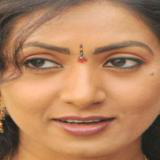

In [124]:
k = 3
print(dataset.idx_to_class[biometricDataset.__getitem__(k)[1]])
biometricDataset.__getitem__(k)[0]

In [125]:
biometricDataset.add((1,0))

n000004


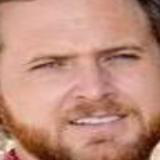

In [126]:
k = 300
print(dataset.idx_to_class[biometricDataset.__getitem__(k)[1]])
biometricDataset.__getitem__(k)[0]

In [127]:
initial_database

{0: 0,
 1: 387,
 2: 871,
 3: 1144,
 4: 1300,
 5: 1680,
 6: 1994,
 7: 2239,
 8: 2522,
 9: 2893,
 10: 3289,
 11: 3738,
 12: 4047,
 13: 4315,
 14: 4620,
 15: 5139,
 16: 5496,
 17: 5802,
 18: 6039,
 19: 6428,
 20: 6692,
 21: 7185,
 22: 7548,
 23: 7878,
 24: 8093,
 25: 8529,
 26: 8927,
 27: 9254,
 28: 9466,
 29: 9904,
 30: 10354,
 31: 10719,
 32: 11064,
 33: 11559,
 34: 11935,
 35: 12256,
 36: 12693,
 37: 13070,
 38: 13409,
 39: 13919,
 40: 14317,
 41: 14637,
 42: 14943,
 43: 15245,
 44: 15693,
 45: 16287,
 46: 16784,
 47: 17238,
 48: 17671,
 49: 18056,
 50: 18305,
 51: 18481,
 52: 18913,
 53: 19127,
 54: 19552,
 55: 20155,
 56: 20637,
 57: 20983,
 58: 21468,
 59: 21842,
 60: 22287,
 61: 22802,
 62: 23027,
 63: 23427,
 64: 23903,
 65: 24414,
 66: 24696,
 67: 24913,
 68: 25305,
 69: 25720,
 70: 26069,
 71: 26434,
 72: 26750,
 73: 27060,
 74: 27487,
 75: 27859,
 76: 28192,
 77: 28417,
 78: 28847,
 79: 29293,
 80: 29660,
 81: 29910,
 82: 30224,
 83: 30627,
 84: 31072,
 85: 31504,
 86: 31990,
 